# Multiple Response Contingency Tables

In [2]:
import numpy as np
import numpy.random as rand
import pandas as pd
from scipy.stats import chi2_contingency

import sys
import os
# let us import local app packages
PACKAGE_PARENT = '../..'
sys.path.append(os.path.normpath(PACKAGE_PARENT))

import matplotlib as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## A basic table:

Contingency tables, also known as "crosstabs", are used to summarize and compare the relationship between two or more experimental factors in a data set. For example, if we conducted a survey asking people 1) their age and 2) their favorite television show, we might want to see whether or not younger people prefer different shows than older people do.

Here's a brief example using simulated data:

In [3]:
age = np.random.choice(['18-36','37-54','55+'], size = 2000, p = [0.3,0.4,0.3]);
favorite_show = np.random.choice(['NCIS','House of Cards','Westworld'], size = 2000, p = [0.2,0.4,0.4])
survey_results = pd.DataFrame({"age": age, "favorite_show": favorite_show})
survey_results.index.name = "respondent_id"
survey_results.head(10)

,age,favorite_show
respondent_id,,
0,18-36,Westworld
1,55+,NCIS
2,18-36,House of Cards
3,18-36,House of Cards
4,37-54,House of Cards
5,18-36,Westworld
6,18-36,Westworld
7,37-54,Westworld
8,37-54,House of Cards


In [4]:
from statsmodels.stats.contingency_tables import Table

table =  Table.from_data(survey_results)
print(table)

Contingency Table: 
favorite_show  House of Cards  NCIS  Westworld
age                                           
18-36                     239   111        245
37-54                     290   163        347
55+                       243   100        262


The above table makes it easy to lookup, for example, how many 18-36-year-olds prefer House of Cards.

With this table in hand we can perform a chi-squared test to evaluate whether or not there is a relationship between age and favorite show:

In [5]:
independence_result = table.test_nominal_association()
print(independence_result)

Contingency Table Independence Result:
chi-squared statistic: 5.094271189311254
degrees of freedom: 4
p value: 0.27776073770329646



As you can see, the p value is (relatively) close to one, indicating that we have very weak evidence to suspect that age affects favorite tv show. That's unsurprising because the data were randomly generated.

## A table with a relationship:

Now let's try again but let's generate data in such a way that we expect a relationship between our factors.

In [6]:
age = np.random.choice(['less than 18','19-36','37+'], size = 2000, p = [0.3,0.4,0.3]);
survey_results = pd.DataFrame({"age": age})
survey_results.index.name = "respondent_id"

def weighted_choice(age):
    # weight tuples: (snapchat, instagram, facebook)
    weights = {'less than 18': (.5, .4, .1),
               '19-36': (.3, .3, .4),
               '37+': (.1, .2, .7)}
    choices = ("snapchat", "instagram", "facebook")
    favorite_network = np.random.choice(choices, p=weights[age])
    return favorite_network

favorite_social_network = survey_results.age.apply(weighted_choice)
survey_results['favorite_social_network'] = favorite_social_network
survey_results.head(10)

,age,favorite_social_network
respondent_id,,
0,37+,instagram
1,37+,facebook
2,37+,facebook
3,less than 18,snapchat
4,less than 18,snapchat
5,less than 18,facebook
6,19-36,facebook
7,37+,facebook
8,19-36,snapchat


In [7]:
from statsmodels.stats.contingency_tables import Table

table =  Table.from_data(survey_results)
print(table)

Contingency Table: 
favorite_social_network  facebook  instagram  snapchat
age                                                   
19-36                         299        255       239
37+                           404        139        70
less than 18                   65        240       289


In [8]:
independence_result = table.test_nominal_association()
print(independence_result)

Contingency Table Independence Result:
chi-squared statistic: 407.3898502024856
degrees of freedom: 4
p value: 0.0



As expected, here our p-value is so low that it rounds to zero. I.e., the contingency table provides extremely strong evidence to suspect that people's age is related to their favorite social network.

## A table with multiple response factors

Most statistical tests that are designed to work with categorical data expect that the categories are mutually exclusive, i.e. each observation will have only one category at a time. For example, if a survey asks "are you a french citizen?" the answer will be either "yes" or "no" or maybe "I don't know" but it'll never be "both" or "neither".

In the real world, especially with survey data, questions often allow multiple answers. For example, a question might ask "which of the following movies have you seen: (Star Wars, The Godfather, Top Five)?" and it would be perfectly valid to answer "Star Wars **and** Top Five".

We are still free to build a contingency table showing the answers to multiple response questions, but these tables violate key assumptions that are required for chi-square tests of independence. So we cannot use traditional chi-square tests to evaluate whether the answers to the questions are independent.

Instead, `statsmodels` provides a different type of contingency table class that will automatically apply independence tests that are valid when applied to multiple response data.

We will walk through an example using a data set extracted from a survey of undecided swing state of voters taken before at the 2016 presidential election. The data set is available in statsmodels as `presidential2016`.

In [9]:
import statsmodels.api as sm
from statsmodels.datasets import presidential2016

data = sm.datasets.presidential2016.load_pandas()
data.data.head()

,Hillary_Clinton,Donald_Trump,Jill_Stein,Gary_Johnson,None_Of_The_Above,I_Probably_Wont_Vote,Hillary_Clinton_is_involved_in_many_coverups,Trump_changes_his_positions_all_of_the_time,Hillary_Clinton_lied_to_the_families_of_Americans_killed_in_Benghazi,Trump_is_a_successful_businessman,Trumps_temper_could_get_the_country_into_trouble,I_wish_another_candidate_had_won_the_primary,Need_to_do_more_research,Dont_like__any_candidate,Not_sure_which_candidate_shares_my_values,Waiting_for_debates
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


The first question asked "Which candidate do you think you are most likely to ultimately vote for in the 2016 presidential election?" The answers are in columns 1 through 6, with a '1' representing 'selected' and '0' representing 'not selected'. Each respondent was only allowed to select 1 candidate, making this a traditional single select categorical variable. 

The second question asked "Please check all of the statements you believe are true" and presented respondents with a list of assertions (shown in columns 7 through 11). Respondents could check as many options as they liked, making this a multiple response question.

The third question asked "Please select any factors that contribute to your not being sure who you'll vote for". The reasons shown in columns 12 through 16 were shown and respondents could pick as many as they liked, making this also a multiple response question.

### Single response versus multiple response

The appropriate statistical tests are somewhat different depending on whether we are comparing two multiple response variables vs. whether we are comparing one multiple response variable versus one single response variable.

We will start with a single response versus a multiple response by comparing the first survey question versus the second.

In [10]:
from statsmodels.stats.contingency_tables import Factor, MRCVTable

In [16]:
rows_factor = Factor(data.data.iloc[:, :6], "expected_choice", orientation="wide")
columns_factor = Factor(data.data.iloc[:, 6:11], "believe_true", orientation="wide")
multiple_response_table = MRCVTable([rows_factor,], [columns_factor])
multiple_response_table

factor_level_col      Hillary_Clinton_is_involved_in_many_coverups  \
factor_level_row                                                     
Donald_Trump                                                    51   
Gary_Johnson                                                    23   
Hillary_Clinton                                                 22   
I_Probably_Wont_Vote                                            36   
Jill_Stein                                                       4   
None_Of_The_Above                                               34   

factor_level_col      Hillary_Clinton_lied_to_the_families_of_Americans_killed_in_Benghazi  \
factor_level_row                                                                             
Donald_Trump                                                         45                      
Gary_Johnson                                                         18                      
Hillary_Clinton                                                

In [17]:
number_of_selections = multiple_response_table.table.sum().sum()
number_of_respondents = len(data.data)
"{number_of_respondents} respondents selected {number_of_selections} items".format(number_of_respondents=number_of_respondents,
                                                                      number_of_selections=number_of_selections)

'1000 respondents selected 683 items'

#### What "independence" means for multiple response questions

We'd like to investigate whether there was a relationship between undecided voters factual beliefs and the candidate they expected to vote for.

It's straight forward to build a contingency table that tabulates the number of people supporting each candidate who said they held each belief. But this table has a key difference from the "age vs. social network" table above: the "grand total" (the sum of the values in all of the table cells together) is *not the same as than the number of people who took the survey* (in this case, 1000 survey respondents said they believed 683 assertions. That means that a substantial number of respondents said they did not believe any of these assertions). 

Traditional chi-squared tests work by 1) assuming independence between the factors, 2) calculating an "expected value" for each cell in a contingency table, 3) seeing how much the observed values in the table differ from the expected values, 4) testing how likely it would be to see a deviation as large as the one we observe if the factors actually were unrelated (and thus the deviation arose from randomness in the sampling process rather than an underlying relationship between the factors).

The last step, figuring out how likely and observed deviation is, requires assuming a probability distribution for the deviations. And as the name suggests, the chi-squared test uses the [chi-squared distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution). But the chi-squared distribution has a parameter (the "degrees of freedom") that determines its shape. When the categories in a contingency table are mutually exclusive (i.e. the survey questions are 'single-select') we can use the the total number of cells in the table as the degrees of freedom parameter.

When the categories are *not* mutually exclusive (i.e. because they're "multiple response", as in this example) then the key assumptions that allowed us to use the chi-squared distribution break down and it is no longer straight-forward to evaluate how unlikely a set of observed deviations are. 

To move forward, we need to slightly change our perspective. Instead of thinking about a multiple response question as "one question with multiple selections" we can think of it as "multiple questions, each with a single selection". I.e. the question "select all that apply: (A, B, C, D)" is equivalent to "does A apply (yes/no)? Does B apply (yes/no)? Does C apply (yes/no)? (etc.)"

Then instead of asking "is the candidate a respondent supports independent of the statements she believes are true", we can ask "is the candidate a respondent supports simultaneously independent of whether she believes statement A **and** whether she believes statement B **and** whether she believes statement C (etc.)". This new question is called **marginal mutual independence (MMI)**, i.e. whether the answer to a single response question is simultaneously independent of whether a respondent selected or did not select each possible answer to a multiple response question.

Similarly, if we're comparing two (or more) multiple response questions against each other, we ask "is whether a respondent selected option A on question 1 independent of whether she selected option A on question 2 **and** whether she selected option B on question 2 **and** is whether she selected option B on question 1 independent of whether she selected option A on question 2 (etc.)" This concept is called **simultaneous pairwise mutual independence (SPMI)**, i.e. whether each possible choice on one multiple response question is simultaneously indepedent of each possible choice on a different multiple response question.

The `MRCVTable` class provides functionality for evaluating **marginal mutual independence (MMI)** and **simultaneous pairwise mutual independence (SPMI)**. This example is comparing one single-response question vs. one multiple response question, so the relevant test is for **marginal mutual independence (MMI)**.

The tests for MMI and SPMI all start with the same step: build a big table comparing each combination of answers from the two questions:

In [18]:
multiple_response_table._build_item_response_table_for_MMI(rows_factor, columns_factor)

multiple_response_level Hillary_Clinton_is_involved_in_many_coverups      \
selected?                                                        0.0 1.0   
single_response_level                                                      
Donald_Trump                                                     131  51   
Gary_Johnson                                                      86  23   
Hillary_Clinton                                                  205  22   
I_Probably_Wont_Vote                                             180  36   
Jill_Stein                                                        35   4   
None_Of_The_Above                                                193  34   

multiple_response_level Hillary_Clinton_lied_to_the_families_of_Americans_killed_in_Benghazi  \
selected?                                                                                0.0   
single_response_level                                                                          
Donald_Trump                                                           137                     
Gary_Johnson                                                            91                     
Hillary_Clinton                                                        209                     
I_Probably_Wont_Vote                                                   197                     
Jill_Stein                                                              36                     
None_Of_The_Above                                                      200                     

multiple_response_level     Trump_changes_his_positions_all_of_the_time      \
selected?               1.0                                         0.0 1.0   
single_response_level                                                         
Donald_Trump             45                                         172  10   
Gary_Johnson             18                                          92  17   
Hillary_Clinton          18                                         176  51   
I_Probably_Wont_Vote     19                                         192  24   
Jill_Stein                3                                          27  12   
None_Of_The_Above        27                                         201  26   

multiple_response_level Trump_is_a_successful_businessman      \
selected?                                             0.0 1.0   
single_response_level                                           
Donald_Trump                                          143  39   
Gary_Johnson                                           93  16   
Hillary_Clinton                                       206  21   
I_Probably_Wont_Vote                                  194  22   
Jill_Stein                                             34   5   
None_Of_The_Above                                     206  21   

multiple_response_level Trumps_temper_could_get_the_country_into_trouble      
selected?                                                            0.0 1.0  
single_response_level                                                         
Donald_Trump                                                         168  14  
Gary_Johnson                                                          96  13  
Hillary_Clinton                                                      185  42  
I_Probably_Wont_Vote                                                 197  19  
Jill_Stein                                                            32   7  
None_Of_The_Above                                                    203  24

Using this full item response table, that we can easily look 1 at a time at the relationship between the single response question and the individual choice options for the multiple response question. So for example we could look at the column for "Trump_is_a_successful_businessman" and compare whether or not respondent said yes to that statement versus which candidate she is most likely to support. We can then calculate chi-squared statistic for just that subtable. Then we repeat that process for each subtable: 

In [19]:
multiple_response_table._calculate_pairwise_chi2s_for_MMI_item_response_table(rows_factor, columns_factor)

factor_level
Hillary_Clinton_is_involved_in_many_coverups                            27.493592
Trump_changes_his_positions_all_of_the_time                             36.511000
Hillary_Clinton_lied_to_the_families_of_Americans_killed_in_Benghazi    33.065276
Trump_is_a_successful_businessman                                       19.305086
Trumps_temper_could_get_the_country_into_trouble                        16.238789
dtype: float64

And now the hard part: each individual sub table does satisfy the requirements for a chi-square test so we could perform a chi-square test and get a p value for each sub table. The p value for each subtable reflects the likelihood of a deviation as large as we see in the specific sub table could appear by chance. But what we actually care about is the likelihood that the deviations we see in each of the sub tables could appear all at the same time.

So we need a correction for the fact that we are considering multiple tables at once.

The simplest correction to apply is the bonferroni correction, where we find the sub table with the lowest p value and then multiply that p value by the number of sub tables. The result is our overall p value for the relationship between the questions.

In [20]:
bonferroni_test = multiple_response_table._test_for_marginal_mutual_independence_using_bonferroni_correction
results = bonferroni_test(rows_factor, columns_factor)
table_p_value_bonferroni_corrected, pairwise_bonferroni_corrected_p_values = results
print("Overall table p value: {}\n\n".format(table_p_value_bonferroni_corrected))
print("Pairwise p values (likelihood of independence between single select variable and specific multi-select option):")
pairwise_bonferroni_corrected_p_values

Overall table p value: 3.752624460014494e-06


Pairwise p values (likelihood of independence between single select variable and specific multi-select option):


factor_level
Hillary_Clinton_is_involved_in_many_coverups                            0.000229
Trump_changes_his_positions_all_of_the_time                             0.000004
Hillary_Clinton_lied_to_the_families_of_Americans_killed_in_Benghazi    0.000018
Trump_is_a_successful_businessman                                       0.008431
Trumps_temper_could_get_the_country_into_trouble                        0.030972
dtype: float64

Compare this p value to what we would get if we naively applied traditional chi-squared test to the simple starting contingency table just tabulated the responses:

In [21]:
_,  traditional_chi2_p_value, _, _ = chi2_contingency(multiple_response_table.table)
print("Naive chi-squared p value: {}".format(traditional_chi2_p_value))
ratio = table_p_value_bonferroni_corrected / traditional_chi2_p_value  
print("The naive chi-squared method overstates our confidence by a factor of {}".format(ratio))

Naive chi-squared p value: 1.7079214808649325e-09
The naive chi-squared method overstates our confidence by a factor of 2197.187928167561


In this particular case using the naive method that is overconfident by almost 3 orders of magnitude (i.e. it is much too quick to reject the null hypothesis of independence)

A well-known problem with bonferroni correction is that it it can be too conservative (i.e. it can require an inefficiently large amount of evidence in order to reject the null hypothesis). 

Another test we have available use of the Rao Scott Second Order Correction to give us a p value which does not use inappropriate assumptions but is hopefully less conservative than the Bonferroni corrected p value.

In [22]:
rao_scott_test = multiple_response_table._test_for_marginal_mutual_independence_using_rao_scott_2
table_p_value_rao_scott_corrected = rao_scott_test(rows_factor, columns_factor)
print("Overall table p value: {}\n\n".format(table_p_value_rao_scott_corrected))

Overall table p value: 3.7969627442180354e-14




In this case the Rao Scott adjusted test is much less conservative, even compared to the naive chi-squared test. In this case the p value is so low that it rounds to zero.

## Multiple response versus multiple response

When we compare two (or more) multiple response questions against each other (e.g. question 2 versus question 3 in our sample presidential survey), we test for **simultaneous pairwise mutual independence (SPMI)**, i.e. whether each possible choice on one multiple response question is simultaneously indepedent of each possible choice on a different multiple response question.

Once again, we treat each multiple response question as a compound of individual "sub-questions", one for each answer option (i.e. "does A apply (yes/no)? Does B apply (yes/no)?" Then we say that the multiple response questions have simultaneous pairwise mutual independence if each answer choice in the first question is simultaneously independent of each answer choice in the second question.

As before we start by building a full "item response table" comparing answer choice on the first question each answer choice on the second question:


In [25]:
rows_factor = Factor(data.data.iloc[:, 6:11], "believe_true", orientation="wide")
columns_factor = Factor(data.data.iloc[:, 11:], "why_uncertain", orientation="wide")


In [26]:
multiple_response_table._build_item_response_table_for_SPMI(rows_factor, columns_factor)

column_levels                                                I_wish_another_candidate_had_won_the_primary  \
selected?                                                                                             0.0   
row_levels                                         selected?                                                
Hillary_Clinton_is_involved_in_many_coverups       0.0                                                683   
                                                   1.0                                                121   
Trump_changes_his_positions_all_of_the_time        0.0                                                703   
                                                   1.0                                                101   
Hillary_Clinton_lied_to_the_families_of_America... 0.0                                                685   
                                                   1.0                                                119   
Trump_is_a_successful_businessman                  0.0                                                715   
                                                   1.0                                                 89   
Trumps_temper_could_get_the_country_into_trouble   0.0                                                692   
                                                   1.0                                                112   

column_levels                                                      \
selected?                                                     1.0   
row_levels                                         selected?        
Hillary_Clinton_is_involved_in_many_coverups       0.0        147   
                                                   1.0         49   
Trump_changes_his_positions_all_of_the_time        0.0        157   
                                                   1.0         39   
Hillary_Clinton_lied_to_the_families_of_America... 0.0        185   
                                                   1.0         11   
Trump_is_a_successful_businessman                  0.0        161   
                                                   1.0         35   
Trumps_temper_could_get_the_country_into_trouble   0.0        189   
                                                   1.0          7   

column_levels                                                Need_to_do_more_research  \
selected?                                                                         0.0   
row_levels                                         selected?                            
Hillary_Clinton_is_involved_in_many_coverups       0.0                            661   
                                                   1.0                            155   
Trump_changes_his_positions_all_of_the_time        0.0                            702   
                                                   1.0                            114   
Hillary_Clinton_lied_to_the_families_of_America... 0.0                            713   
                                                   1.0                            103   
Trump_is_a_successful_businessman                  0.0                            709   
                                                   1.0                            107   
Trumps_temper_could_get_the_country_into_trouble   0.0                            715   
                                                   1.0                            101   

column_levels                                                      \
selected?                                                     1.0   
row_levels                                         selected?        
Hillary_Clinton_is_involved_in_many_coverups       0.0        169   
                                                   1.0         15   
Trump_changes_his_positions_all_of_the_time        0.0        158   
                                                   1.0         26   
Hillary_Clinton_lied_to_the_families_of_Ame

Now as before we can calculate a chi-squared statistic for each individual pairing of column level and row level:


In [27]:
multiple_response_table._calculate_pairwise_chi2s_for_SPMI_item_response_table(rows_factor, columns_factor)

column_levels,I_wish_another_candidate_had_won_the_primary,Need_to_do_more_research,Dont_like__any_candidate,Not_sure_which_candidate_shares_my_values,Waiting_for_debates
row_levels,,,,,
Hillary_Clinton_is_involved_in_many_coverups,11.0574,12.5105,17.2742,0.0228698,5.21583
Trump_changes_his_positions_all_of_the_time,7.04331,0.00318631,2.74341,1.38182,4.01368
Hillary_Clinton_lied_to_the_families_of_Americans_killed_in_Benghazi,11.7642,0.558638,9.74002,0.402103,16.0883
Trump_is_a_successful_businessman,6.68351,2.07403,10.0131,0.0193256,4.48833
Trumps_temper_could_get_the_country_into_trouble,16.1294,0.964289,22.8695,8.56061,0.236957


Now we have to determine how likely it is to get chi-squared statistics this large in each of those cells of the same time. Once again the simplest way to do that is to apply a bonferroni correction, i.e. calculate a p value for each cell using a chi-square distribution and multiply the p value by the total number of cells. 

In [28]:
bonferroni_test = multiple_response_table._test_for_single_pairwise_mutual_independence_using_bonferroni
results = bonferroni_test(rows_factor, columns_factor)
table_p_value_bonferroni_corrected, pairwise_bonferroni_corrected_p_values = results
print("Overall table p value: {}\n\n".format(table_p_value_bonferroni_corrected))
print("Pairwise p values (likelihood of independence between single select variable and specific multi-select option):")
pairwise_bonferroni_corrected_p_values

Overall table p value: 4.3346430242129665e-05


Pairwise p values (likelihood of independence between single select variable and specific multi-select option):


column_levels,I_wish_another_candidate_had_won_the_primary,Need_to_do_more_research,Dont_like__any_candidate,Not_sure_which_candidate_shares_my_values,Waiting_for_debates
row_levels,,,,,
Hillary_Clinton_is_involved_in_many_coverups,0.022083,0.010117,0.000809,1.000000,0.559553
Trump_changes_his_positions_all_of_the_time,0.198904,1.000000,1.000000,1.000000,1.000000
Hillary_Clinton_lied_to_the_families_of_Americans_killed_in_Benghazi,0.015095,1.000000,0.045075,1.000000,0.001511
Trump_is_a_successful_businessman,0.243271,1.000000,0.038857,1.000000,0.853173
Trumps_temper_could_get_the_country_into_trouble,0.001479,1.000000,0.000043,0.085879,1.000000


Let's compare this result versus the p value we would get by applying a traditional chi-squared test:

In [29]:
_,  traditional_chi2_p_value, _, _ = chi2_contingency(multiple_response_table.table)
print("Naive chi-squared p value: {}".format(traditional_chi2_p_value))
ratio = table_p_value_bonferroni_corrected / traditional_chi2_p_value  
print("The naive chi-squared method overstates our confidence by a factor of {}".format(ratio))

Naive chi-squared p value: 1.7079214808649325e-09
The naive chi-squared method overstates our confidence by a factor of 25379.63877600391


In this case the traditional chi-squared test overstates our confidence by four orders of magnitude.

However we know that the bonferroni-adjustment can be conservative so we can try a 2nd order Rao Scott correction:

In [30]:
rao_scott_test = multiple_response_table._test_for_single_pairwise_mutual_independence_using_rao_scott_2
table_p_value_rao_scott_corrected = rao_scott_test(rows_factor, columns_factor)
print("Overall table p value: {}\n\n".format(table_p_value_rao_scott_corrected))

Overall table p value: 0.0




Both the bonferroni and the row scott methods require us to make some assumptions about the distribution of the deviations we observe in our response table. Ever not comfortable making assumptions we can instead use a nonparametric method by running a bootstrap simulation to approximate the distribution of deviations. The bootstrap method is more computationally intensive but allows us to estimate the p value using fewer assumptions.

## Appendix A: Validating size

In [31]:
def build_random_single_select():
    car_type = np.random.randint(3, size=(10000)) + 1
    base_pop = pd.DataFrame(car_type).reset_index()
    base_pop.columns = ['person', 'choice']
    base_pop['_response'] = 1
    dataframe = pd.pivot_table(base_pop,
                               values='_response',
                               fill_value=0,
                               index='person',
                               columns='choice',
                               aggfunc=np.sum,
                               margins=False)
    car_choice = dataframe.copy()
    car_choice.columns = ["sedan", "truck", "motorcycle"]
    return car_choice

In [32]:
food_choices = pd.DataFrame(np.random.randint(2, size=(10000, 5)),
                                columns=["eggs", "cheese", "candy", "sushi", "none"])
car_choice = build_random_single_select()
language = pd.DataFrame(np.random.randint(2, size=(10000, 5)),
                                columns=["English", "French", "Mandarin", "Hungarian", "none"])

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


0.018

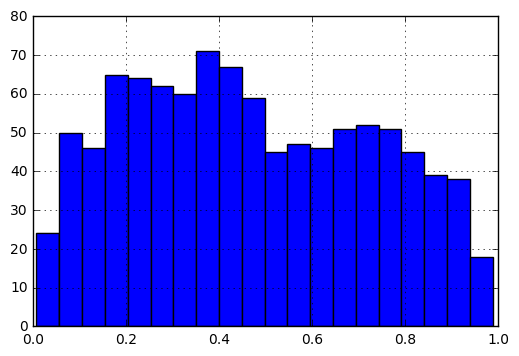

In [35]:
n = 1000
k = 1000
p_values = []
for i in range(0, k):
    if i % 50 == 0:
        print(i)
    srcv = Factor(car_choice.sample(n), "car_choice", orientation="wide")
    mrcv = Factor(food_choices.sample(n), "food_choices", orientation="wide")
    multiple_response_table = MRCVTable([srcv, ], [mrcv,])
    rao_scott_2_test = multiple_response_table._test_for_marginal_mutual_independence_using_rao_scott_2
    table_p_value = rao_scott_2_test(srcv, mrcv)
    p_values.append(table_p_value)
np.mean(p_values)

p_value_series = pd.Series(p_values)
p_value_series.hist(bins=20)
len(p_value_series[p_value_series < 0.05]) / len(p_value_series)

## Appendix B -- Degenerate Cases

In [99]:
import contingency_tables as ctab
a = np.ones((1000, 2))
b = np.ones((1000, 2))
labels = ["Yes", "No"]
mrcv_1 = ctab.Factor.from_array(a, labels, "alive", orientation="wide", multiple_response=True)
mrcv_2 = ctab.Factor.from_array(b, labels, "cool", orientation="wide", multiple_response=True)
multiple_response_table = ctab.MRCVTable([mrcv_1, ], [mrcv_2, ])
multiple_response_table.test_for_independence()

(nan, column_levels  Yes  No
 row_levels            
 Yes            NaN NaN
 No             NaN NaN)

In [68]:
a = pd.DataFrame(np.random.randint(2, size=(1000, 2)),
                             columns=["good", "bad"])
b = pd.DataFrame(np.random.randint(2, size=(1000, 2)),
                         columns=["eggs", "cheese"])
mrcv_1 = ctab.Factor(a, "alive", orientation="wide", multiple_response=True)
mrcv_2 = ctab.Factor(b, "cool", orientation="wide", multiple_response=True)
multiple_response_table = ctab.MRCVTable([mrcv_1, ], [mrcv_2, ])
multiple_response_table.test_for_independence()

[23] > /Users/gjlondon/programming/open_source/statsmodels/statsmodels/stats/contingency_tables.py(1673)_calculate_pairwise_chi2s_for_SPMI_item_response_table()
-> crosstab = item_response_table.iloc[(i, i+1), (j, j+1)]
(Pdb++) c
[23] > /Users/gjlondon/programming/open_source/statsmodels/statsmodels/stats/contingency_tables.py(1672)_calculate_pairwise_chi2s_for_SPMI_item_response_table()
-> pdb.set_trace()
(Pdb++) c
[23] > /Users/gjlondon/programming/open_source/statsmodels/statsmodels/stats/contingency_tables.py(1673)_calculate_pairwise_chi2s_for_SPMI_item_response_table()
-> crosstab = item_response_table.iloc[(i, i+1), (j, j+1)]
(Pdb++) c
[23] > /Users/gjlondon/programming/open_source/statsmodels/statsmodels/stats/contingency_tables.py(1672)_calculate_pairwise_chi2s_for_SPMI_item_response_table()
-> pdb.set_trace()
(Pdb++) c


(0.14705186806951062, column_levels      eggs    cheese
 row_levels                       
 good           0.515752  0.147052
 bad            1.000000  1.000000)

In [87]:
np.array([[1000.5, 0.5],[0.5,0.5]]).shape

(2, 2)

In [88]:
from scipy.stats import chi2_contingency, chi2

chi2_contingency(np.array([[1000.5, 0.5],[0.5,0.5]]), correction=False)

(249.99975049925098,
 2.5971322980052269e-56,
 1,
 array([[  1.00000100e+03,   9.99001996e-01],
        [  9.99001996e-01,   9.98003992e-04]]))

In [61]:
mrcv_1.cast_wide_to_narrow().cast_narrow_to_wide()

Factor at 4686880160 :: Factor: alive
Columns:Index(['No', 'Yes'], dtype='object', name='factor_level')
Data:
factor_level    No  Yes
observation_id         
0                0    0
1                0    0
2                0    0
3                0    0
4                0    0
5                0    0
6                0    0
7                0    0
8                0    0
9                0    0
10               0    0
11               0    0
12               0    0
13               0    0
14               0    0
15               0    0
16               0    0
17               0    0
18               0    0
19               0    0
20               0    0
21               0    0
22               0    0
23               0    0
24               0    0
25               0    0
26               0    0
27               0    0
28               0    0
29               0    0
...             ..  ...
970              0    0
971              0    0
972              0    0
973              0    0
97

In [54]:
multiple_response_table.table

factor_level_row


In [50]:
np.array([0,0]).min()

0

In [46]:
mrcv_1.multiple_response

True

In [ ]:
oDc or OMC for oracle
adobe marketing cloud revenue broken out